In [6]:
# importing necessary modules.
import pandas as pd
import config5 as cfg
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [7]:
# creating a connection to an aws rds postgres cloud database.
rds_connection_string = f'postgres:{cfg.password}@test-db.cy2enoewwvsi.us-east-2.rds.amazonaws.com:5432/stocks_db'
engine = create_engine(f'postgres://{rds_connection_string}')

In [8]:
# checking out the table names in the database.
engine.table_names()

['sandp', 'russell_2000', 'sandp_russell']

In [9]:
# checking out the SandP_500 table.
russell = pd.read_sql_query('SELECT * FROM russell_2000', con=engine)
russell.head()

,symbol,name,price_to_bookvalue,price_to_book,price_to_sales,price_to_earnings,receivables_turnover,price_to_free_cash_flow,price_to_operating_cash_flow,enterprise_value_multiple,gross_profit_margin,pretax_profit_margin,net_profit_margin,tax_rate,return_on_assets,return_on_equity,return_on_capital_employed,receivables_turnover_1,payables_turnover,inventory_turnover,fixed_asset_turnover,asset_turnover,current_ratio,quick_ratio,cash_ratio,days_of_sales_outstanding,days_of_inventory_outstanding,operating_cycle,days_of_payables_outstanding,cash_conversion_cycle,debt_ratio,debt_to_equity_ratio,longterm_debt_to_capitalization,total_debt_to_capitalization,interest_coverage,cash_flow_to_debt,company_equity_multiplier,operating_cash_flow_per_share,free_cash_flow_per_share,cash_per_share,payout_ratio,receivables_turnover_2,operating_cash_flow_to_sales,free_cash_flow_to_operating_cash_flow,cash_flow_coverage_ratio,short_term_coverage_ratio,capital_expenditure_coverage_ratio,dividend_capex_coverage_ratio,dividend_payout_ratio,gross_profit_growth,ebit_growth,operating_income_growth,net_income_growth,eps_growth,eps_diluted_growth,weighted_average_share_growth,weighted_averages_shares_diluted_growth,dividents_per_share_growth,operating_cash_flow_growth,free_cash_flow_growth,ten_year_revenue_growth_per_share,five_year_revenue_growth_per_share,three_year_revenue_growth_per_share,ten_year_operating_cf_growth_per_share,five_year_operating_cf_growth_per_share,three_year_operating_cf_growth_per_share,ten_year_net_income_growth_per_share,five_year_net_income_growth_per_share,three_year_net_income_growth_per_share,ten_year_shareholders_equity_growth_per_share,five_year_shareholders_equity_growth_per_share,three_year_shareholders_equity_growth_per_share,ten_year_dividend_growth_per_share,five_year_dividend_growth_per_share,three_year_dividend_growth_per_share,receivables_growh,inventory_growth,asset_growth,book_value_per_share_growth,debt_growth,randd_expense_growth,sganda_expense_growth,percent_return_on_investment,above_below_sandp_return
0,AAN,"Aaron's, Inc.",1.5315,1.95610,0.78855,12.37860,27.77570,59.12785,19.92670,0.126805,0.812846,0.103087,0.063665,0.370173,-99.00000,0.12390,-99.0000,27.77570,2.51545,-99.00000,1.896709,1.287786,-99.0000,-99.000000,-99.000000,-99.00000,13.65740,-99.0,39.02640,-99.0,0.03475,0.05235,-99.00000,-99.000000,52.30040,-99.000000,1.511503,1.49430,1.0025,1.11840,0.0335,27.77570,0.068380,0.534764,-99.000000,-99.000000,2.842923,2.589789,0.033015,0.08960,0.13155,0.14805,0.14990,0.14025,0.14265,0.00495,-99.0000,-0.04145,0.34920,0.30845,0.12320,0.10100,0.11485,-0.05900,0.19295,0.10960,0.1370,0.1398,0.13275,0.14685,0.16275,0.13400,0.14745,0.09225,0.0635,0.08230,-99.00000,0.10410,0.12870,-0.38070,-99.00000,0.08135,153.807704,1
1,AAON,"AAON, Inc.",3.4176,3.41760,1.63730,16.86505,6.73510,20.69945,10.96230,0.287753,0.250523,0.156079,0.101272,0.349371,0.19970,0.21120,0.2295,6.73510,5.38935,7.68350,3.861265,1.548003,2.8235,1.691296,0.468802,-61.94345,54.61345,-99.0,16.05630,-99.0,0.00025,0.00030,-99.00000,0.000322,2802.70000,297.401316,1.348392,0.67320,0.4370,0.25535,0.2505,6.73510,0.157886,0.623822,297.401316,297.401316,3.272327,2.063600,0.315321,-0.08870,-0.12985,-0.12195,-0.12030,-0.10075,-0.09140,-0.02195,-0.0273,0.06315,0.03135,-0.04620,0.07485,0.08465,0.02745,0.13505,0.24560,0.20095,0.1031,0.2400,0.10900,0.14865,0.11285,0.11065,-99.00000,-99.00000,0.0889,0.02775,-0.02075,0.06795,0.13045,-0.98780,-99.00000,-0.02605,454.948301,1
2,AAT,"American Assets Trust, Inc.",-99.0000,-99.00000,7.06720,261.50000,3.15505,18.73490,17.21230,0.503388,0.741771,0.401037,-99.000000,-99.000000,-99.00000,-99.00000,-99.0000,3.15505,3.00355,-99.00000,0.136901,0.112641,-99.0000,-99.000000,-99.000000,-99.00000,103.81765,-99.0,29.14905,-99.0,0.78660,2.79505,-99.00000,-99.000000,1.00000,-99.000000,3.525456,0.61730,0.5671,0.59290,-99.0000,3.15505,0.416249,0.893146,-99.000000,-99.000000,9.927770,9.927770,-99.000000,-0.01405,0.08685,-0.05805,0.50000,-99.0000

In [10]:
# dropping unnecessary columns.
russell.drop(['symbol', 'name', 'percent_return_on_investment'], axis=1, inplace=True)

In [11]:
# finding features in the sandp dataframe that are more than .80 correlated to help the upcoming process function more efficiently.
correlated_features = set()
correlation_matrix = russell.drop('above_below_sandp_return', axis=1).corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > .80:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [12]:
# viewing correlated features.
correlated_features

{'asset_growth',
 'book_value_per_share_growth',
 'cash_conversion_cycle',
 'cash_flow_coverage_ratio',
 'cash_per_share',
 'cash_ratio',
 'current_ratio',
 'dividend_capex_coverage_ratio',
 'dividend_payout_ratio',
 'five_year_shareholders_equity_growth_per_share',
 'net_profit_margin',
 'operating_cash_flow_to_sales',
 'price_to_book',
 'quick_ratio',
 'receivables_turnover_1',
 'receivables_turnover_2',
 'return_on_capital_employed',
 'ten_year_shareholders_equity_growth_per_share',
 'three_year_dividend_growth_per_share',
 'total_debt_to_capitalization'}

In [13]:
# dropping correlated features.
russell.drop(correlated_features, axis=1, inplace=True)

In [14]:
# viewing dataframe.
russell.head()

,price_to_bookvalue,price_to_sales,price_to_earnings,receivables_turnover,price_to_free_cash_flow,price_to_operating_cash_flow,enterprise_value_multiple,gross_profit_margin,pretax_profit_margin,tax_rate,return_on_assets,return_on_equity,payables_turnover,inventory_turnover,fixed_asset_turnover,asset_turnover,days_of_sales_outstanding,days_of_inventory_outstanding,operating_cycle,days_of_payables_outstanding,debt_ratio,debt_to_equity_ratio,longterm_debt_to_capitalization,interest_coverage,cash_flow_to_debt,company_equity_multiplier,operating_cash_flow_per_share,free_cash_flow_per_share,payout_ratio,free_cash_flow_to_operating_cash_flow,short_term_coverage_ratio,capital_expenditure_coverage_ratio,gross_profit_growth,ebit_growth,operating_income_growth,net_income_growth,eps_growth,eps_diluted_growth,weighted_average_share_growth,weighted_averages_shares_diluted_growth,dividents_per_share_growth,operating_cash_flow_growth,free_cash_flow_growth,ten_year_revenue_growth_per_share,five_year_revenue_growth_per_share,three_year_revenue_growth_per_share,ten_year_operating_cf_growth_per_share,five_year_operating_cf_growth_per_share,three_year_operating_cf_growth_per_share,ten_year_net_income_growth_per_share,five_year_net_income_growth_per_share,three_year_net_income_growth_per_share,three_year_shareholders_equity_growth_per_share,ten_year_dividend_growth_per_share,five_year_dividend_growth_per_share,receivables_growh,inventory_growth,debt_growth,randd_expense_growth,sganda_expense_growth,above_below_sandp_return
0,1.5315,0.78855,12.37860,27.77570,59.12785,19.92670,0.126805,0.812846,0.103087,0.370173,-99.00000,0.12390,2.51545,-99.00000,1.896709,1.287786,-99.00000,13.65740,-99.0,39.02640,0.03475,0.05235,-99.00000,52.30040,-99.000000,1.511503,1.49430,1.0025,0.0335,0.534764,-99.000000,2.842923,0.08960,0.13155,0.14805,0.14990,0.14025,0.14265,0.00495,-99.0000,-0.04145,0.34920,0.30845,0.12320,0.10100,0.11485,-0.05900,0.19295,0.10960,0.1370,0.1398,0.13275,0.13400,0.14745,0.09225,0.08230,-99.00000,-0.38070,-99.00000,0.08135,1
1,3.4176,1.63730,16.86505,6.73510,20.69945,10.96230,0.287753,0.250523,0.156079,0.349371,0.19970,0.21120,5.38935,7.68350,3.861265,1.548003,-61.94345,54.61345,-99.0,16.05630,0.00025,0.00030,-99.00000,2802.70000,297.401316,1.348392,0.67320,0.4370,0.2505,0.623822,297.401316,3.272327,-0.08870,-0.12985,-0.12195,-0.12030,-0.10075,-0.09140,-0.02195,-0.0273,0.06315,0.03135,-0.04620,0.07485,0.08465,0.02745,0.13505,0.24560,0.20095,0.1031,0.2400,0.10900,0.11065,-99.00000,-99.00000,0.02775,-0.02075,-0.98780,-99.00000,-0.02605,1
2,-99.0000,7.06720,261.50000,3.15505,18.73490,17.21230,0.503388,0.741771,0.401037,-99.000000,-99.00000,-99.00000,3.00355,-99.00000,0.136901,0.112641,-99.00000,103.81765,-99.0,29.14905,0.78660,2.79505,-99.00000,1.00000,-99.000000,3.525456,0.61730,0.5671,-99.0000,0.893146,-99.000000,9.927770,-0.01405,0.08685,-0.05805,0.50000,-99.00000,-99.00000,-99.00000,-99.0000,-99.00000,0.00795,0.28355,-99.00000,-99.00000,-99.00000,-99.00000,-99.00000,-99.00000,-99.0000,-99.0000,-99.00000,-99.00000,-99.00000,-99.00000,-0.22290,-99.00000,0.07855,-99.00000,0.02340,0
3,1.1936,0.91035,10.26345,18.45670,5.75450,4.40720,4.241562,0.474941,0.155829,0.384995,0.07510,0.11165,16.89265,-99.00000,1.269505,0.650370,-99.00000,20.30775,-99.0,6.70905,0.28825,0.55185,0.32239,5.30235,0.477610,1.907219,10.39595,8.0345,-99.0000,0.773038,4.221149,4.407457,0.15910,0.31795,6.93425,0.52215,0.36835,0.36340,0.10215,0.1069,-99.00000,0.50980,0.87850,-99.00000,-0.04120,-0.11560,-99.00000,0.30995,0.08635,-99.0000,0.0430,0.01690,0.18750,-99.00000,-99.00000,0.07730,-99.00000,-0.14835,-99.00000,0.01570,0
4,2.4052,2.99445,-99.00000,6.24490,-99.00000,214.55715,15.927844,0.565023,-0.029942,0.506052,-0.02065,-0.01865,5.47565,6.29335,2.558388,0.695718,-145.62380,55.36360,-99.0,20.68265,-99.00000,-99.00000,-99.00000,-99.00000,-99.000000,1.167242,0.08755,-0.0551,-99.0000,-2.406501,-99.000000,0.460631,-0.08615,-28.97660,-32.46545,-1982.11360,-0.50000,-0.50000,0.00130,-0.

In [15]:
# filtering out the important features using Recursive Feature Elimination Cross-Validation Skilearn algorithm.
X = russell.drop('above_below_sandp_return', axis=1)
target = russell['above_below_sandp_return']
rfc = RandomForestClassifier(random_state=100)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators='warn', n_jobs=None,
                                       oob_score=False, random_state=100,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [16]:
# checking out the optimal number of features to use.
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 11


In [17]:
# dropping the least important features.
X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

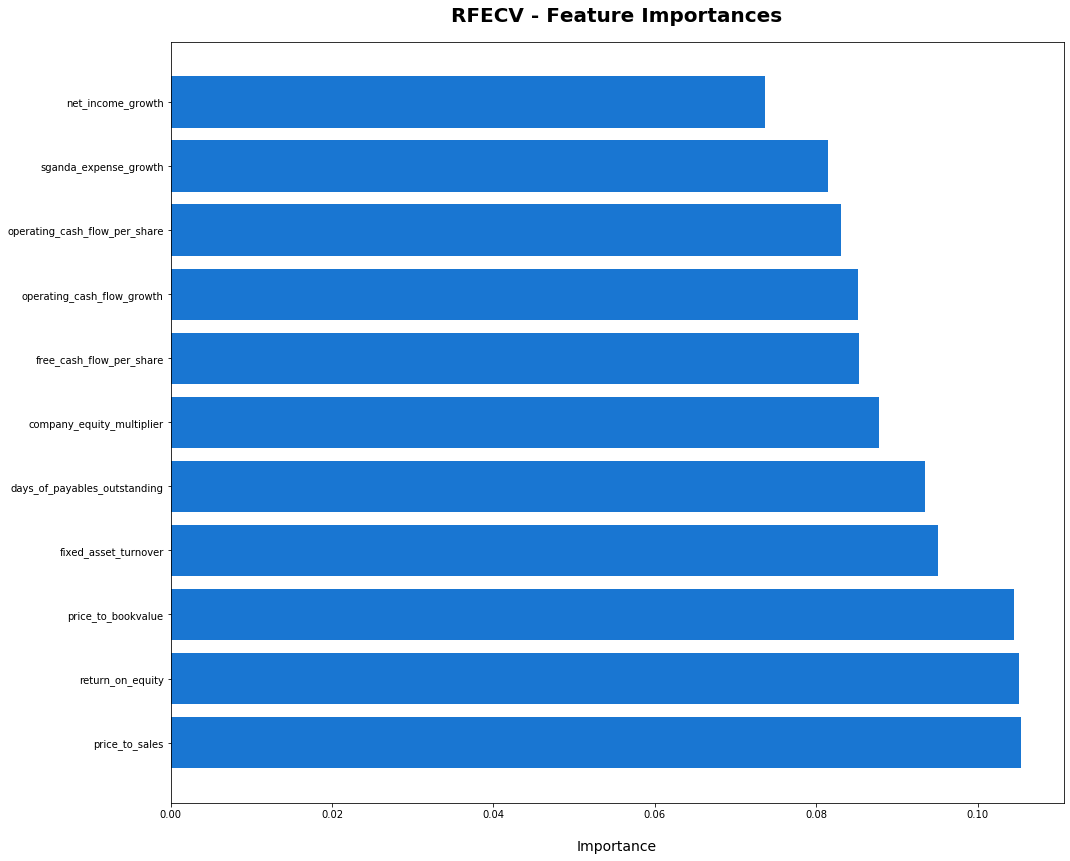

In [18]:
# visualizing the ranking of the features with a horizontal barchart.
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, target_train, target_test = train_test_split(X, target, random_state=1, stratify=target)

In [20]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)

In [21]:
 # Transform the training and testing data using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

k: 1, Train/Test Score: 1.000/0.554
k: 3, Train/Test Score: 0.790/0.602
k: 5, Train/Test Score: 0.740/0.580
k: 7, Train/Test Score: 0.720/0.627
k: 9, Train/Test Score: 0.689/0.631
k: 11, Train/Test Score: 0.689/0.615
k: 13, Train/Test Score: 0.674/0.621
k: 15, Train/Test Score: 0.682/0.608
k: 17, Train/Test Score: 0.663/0.643
k: 19, Train/Test Score: 0.661/0.640


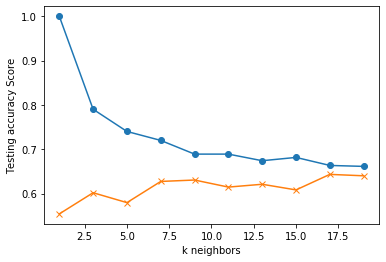

In [22]:
from sklearn.neighbors import KNeighborsClassifier
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, target_train)
    train_score = knn.score(X_train_scaled, target_train)
    test_score = knn.score(X_test_scaled, target_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [26]:
# Note that k: 9 provides the best accuracy where the classifier starts to stablize
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train_scaled, target_train)
print('k=9 Test Acc: %.3f' % knn.score(X_test_scaled, target_test))

k=9 Test Acc: 0.643


In [27]:
target_test.value_counts()

0    198
1    116
Name: above_below_sandp_return, dtype: int64

In [28]:
target.mean()

0.3687150837988827

In [29]:
1- target.mean()

0.6312849162011174